# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science
## Homework 5 Parts 2 & 3: Vision Transformers & Kaggle Competition


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import time

SEED = 109

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-03 11:35:08.817956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 11:35:08.817995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 11:35:08.818636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 11:35:08.823697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes).
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

<a id="contents"></a>

# Notebook Contents

- [**PART 2 [40 pts]: Vison Transformer from Scratch**](#part2)
- [**PART 3 [10 pts]: Kaggle Competition**](#part3)

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
# **PART 2: Vision Transformer from Scratch (40 points)**

Vision Transformers (ViTs) (for more details, see the original paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)) represent a groundbreaking approach in computer vision by adapting the Transformer architecture, originally designed for natural language processing, to image recognition tasks. The key idea is to split an image into a sequence of patches, treat these patches as tokens (much like words in a sentence), and process them with Transformer models. This paradigm shift has enabled ViTs to achieve state-of-the-art performance on various tasks.

In this part of the homework, we will implement a Vision Transformer (ViT) from scratch using TensorFlow. When fine-grained control over the operations in your model is needed, standard Keras layers might not be flexible enough. Creating custom layers, on the other hand, allows you to directly manage each operation within the layer. This not only enables experimentation with novel ideas but also allows you to tailor the model's behavior to its specific requirements. We will build our model using custom layers and train it on a classification task.


---

#### Creating a custom layer

TensorFlow's design specifies that all custom layers should inherit from `tf.keras.layers.Layer` to ensure they integrate seamlessly into its ecosystem (e.g., automatic differentiation, weight management). Inheritance is a fundamental concept in object-oriented programming (OOP) that allows a class (the child or subclass) to inherit attributes and methods from another class (the parent or superclass).


There are **two essential methods** you must implement when creating a custom layer:

1. **Constructor (`__init__`)**  
   - **Purpose:** Sets up the layer.
   - **What to Do:**  
     - Inherit from `tf.keras.layers.Layer` by calling `super().__init__()` or `super(class_name, self).__init__()`.
     - Initialize any trainable parameters or sub-layers.

2. **`call`**  
   - **Purpose:** Defines the forward pass (i.e., how inputs are transformed into outputs).
   - **What to Do:**  
     - Implement the layer’s logic. Whatever computation you need (for example, an element-wise operation) should be written in this method.
     - This method is automatically invoked during model training and inference.


**Example**
```python
import tensorflow as tf

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = x + inputs
        return x
```

**What Happens in __init__:**
- We call `super(ResidualBlock, self).__init__()` to inherit from `tf.keras.layers.Layer`.
- We initialize three Dense layers `dense1`, `dense2` and `dense3`, using ReLU activation in the first two, and linear in the last one.

**What Happens in call:**
- The `call()` method passes the input through the three Dense layers sequentially
- a skip connection adds the original input to the output of the seuqnece of Dense layers.

</div>

## The Quick, Draw! Dataset 

For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 306,000 images across 24 different classes for training (this includes the data you will use for validation) and a test set of 54,000 images.


<a id="part2data"></a>

## Downloading the Data Files


**The required `train.csv` file is available on [the "Data" tab of the CS1090B HW5 Kaggle Competition website](https://www.kaggle.com/t/e067286be2c54c078434793659326610). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**


- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 306,000 samples. This is the only file needed for this part of the homework.

## The Quick, Draw! Dataset 

[Return to contents](#contents)


![](img/quickdrawpreview.jpg)



For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 306,000 images across 24 different classes for training (this includes the data you will use for validation) and a test set of 54,000 images.


<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**The required `train.csv` and `test.csv` data files are available on [the "Data" tab of the CS1090B HW5 Kaggle Competition website](https://www.kaggle.com/t/e067286be2c54c078434793659326610). (DO NOT USE DATA FROM ANY OTHER SOURCE!)** Also please check the overview section for important notes [https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview)

Here's a brief description of the data files:

- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 306,000 samples.

- `test.csv` file mirrors the structure of the `train.csv` file **without** the class label column. We have added another column `id`. `id` is a unique identifier for each sample in the test set. This ID is crucial for mapping your model's predictions back to the corresponding samples when submitting your results to Kaggle. `test.csv` has 54,000 samples. 


In [4]:
def load_data_from_csv(data_file):
    """Load and preprocess data from CSV file"""
    df = pd.read_csv(data_file)

    classes = sorted(df['label'].unique().tolist())
    
    label_to_id = {label: idx for idx, label in enumerate(classes)}
    
    X = df.drop('label', axis=1).values.astype('uint8')
    y = df['label'].map(label_to_id).values 
    
    # Normalize pixel values to [0, 1]
    X = X.astype('float32') / 255.0
    X = X.reshape(-1, 28, 28, 1)
    
    return df, X, y, classes, label_to_id  

# Load and preprocess the data
data_file = "train.csv"
df, X, y, classes, label_to_id = load_data_from_csv(data_file) 

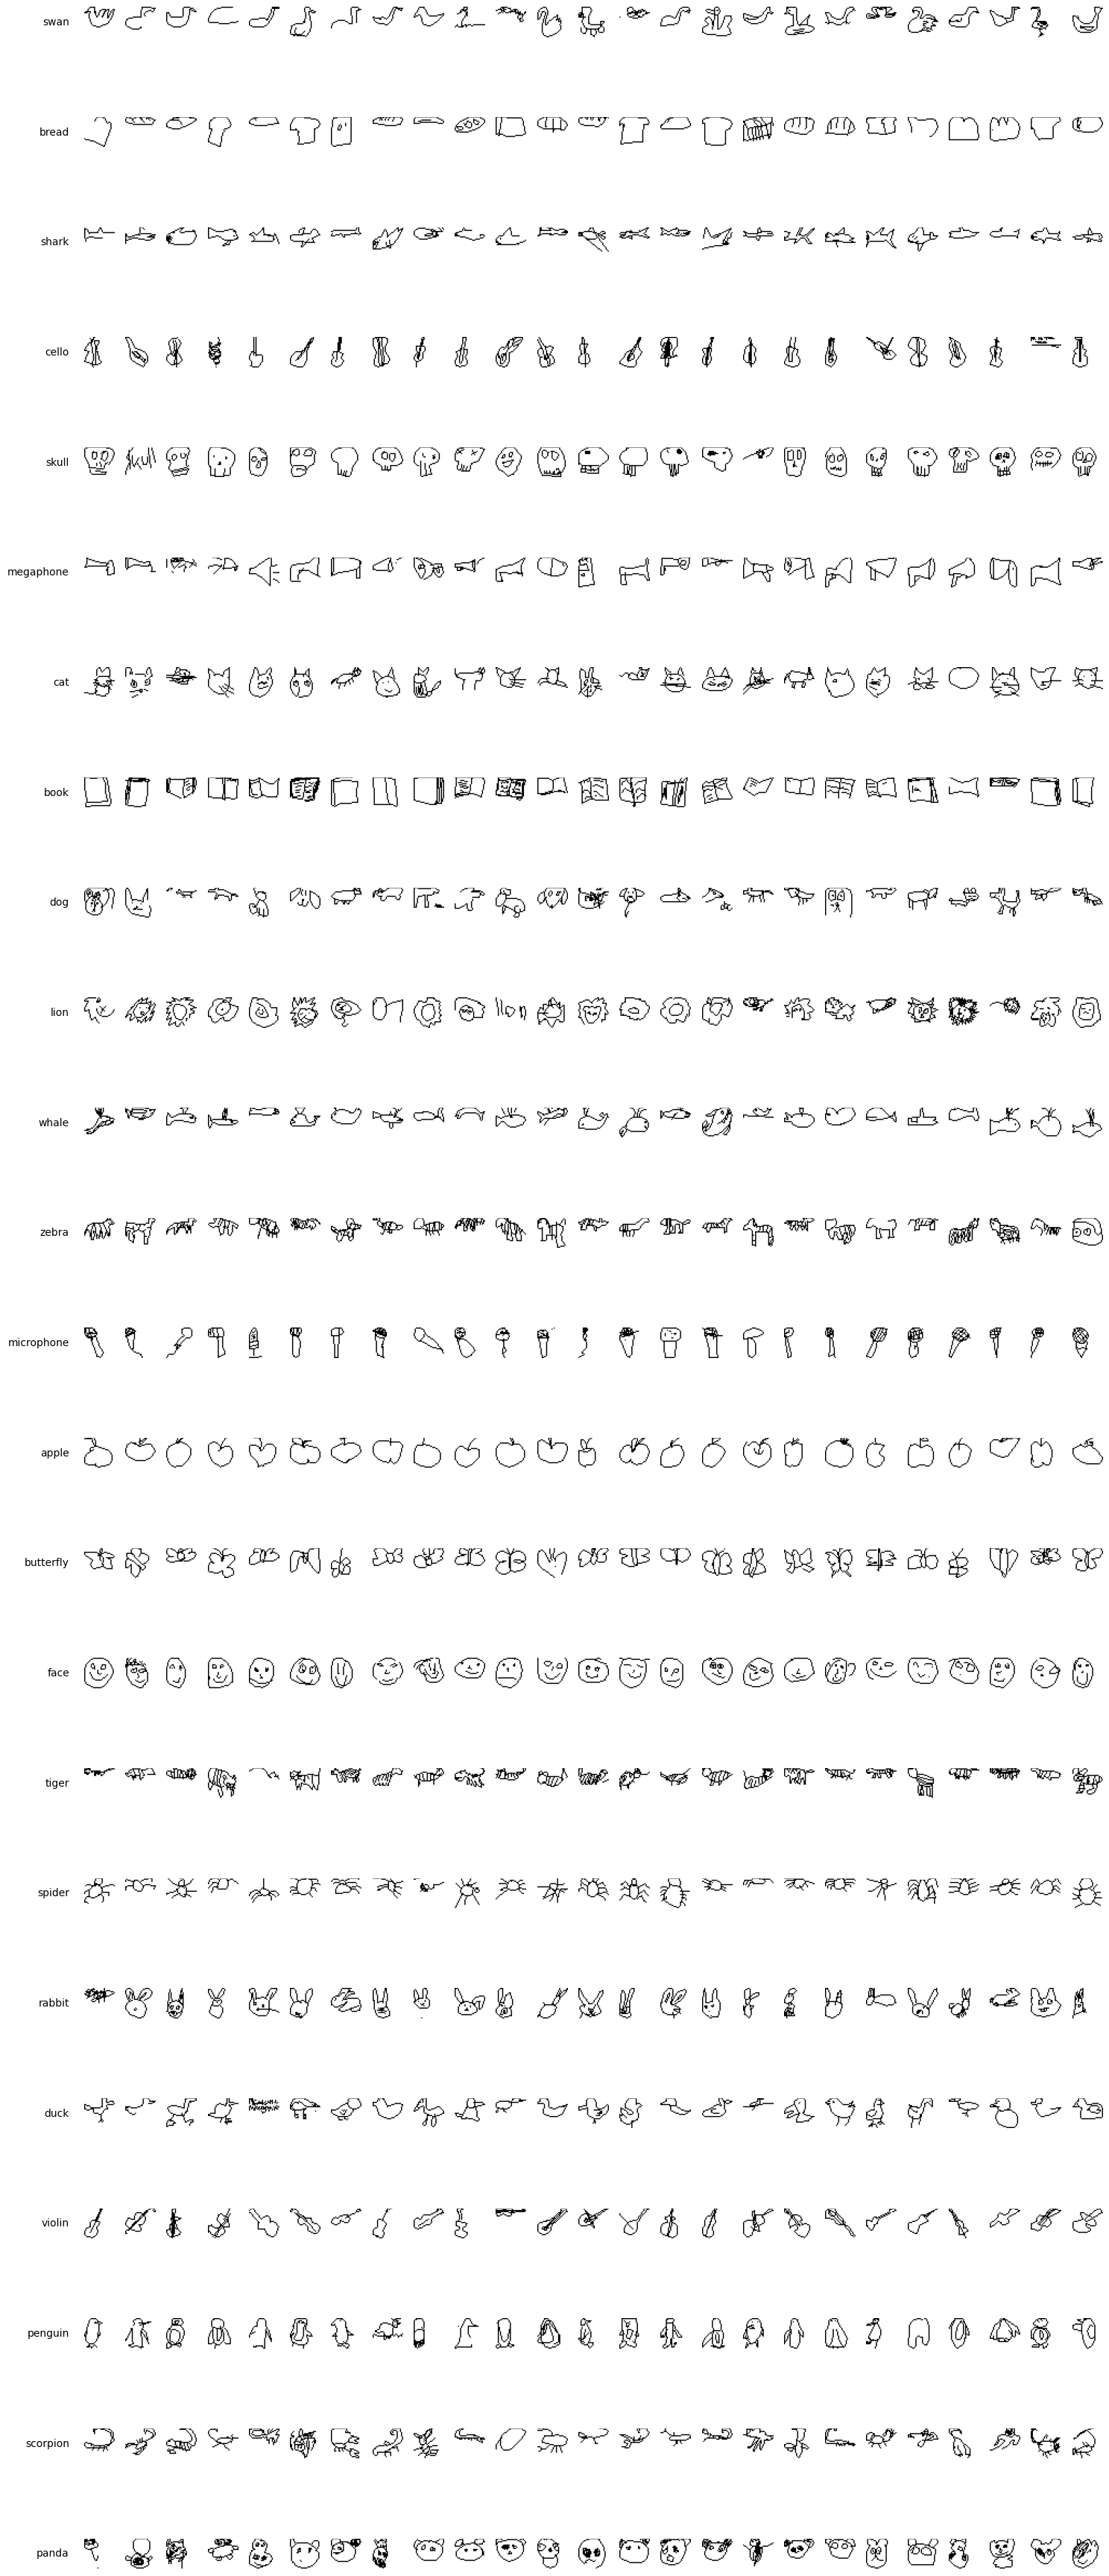

In [5]:
def plot_image_grid(df, classes, rows=5, cols=5):
    """
    Plot a grid of images for each class from the CSV data
    
    Args:
        df: DataFrame containing the image data and labels
        classes: List of class names
        rows: Number of rows in the grid (default 5)
        cols: Number of columns in the grid (default 5)
    """
    # Calculate figure size with reduced height per class
    fig_height = len(classes) * 1.5  
    fig = plt.figure(figsize=(15, fig_height))
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    for idx, class_name in enumerate(classes):
        class_samples = df[df['label'] == class_name].iloc[:rows*cols]
        
        for i in range(rows*cols):
            if i < len(class_samples):
                # Get image data, convert to float32 and normalize to [0,1]
                img_data = class_samples.iloc[i].drop(['label']).values.astype('float32') / 255.0
                img_data = img_data.reshape(28, 28)
                
                # Create subplot
                ax = plt.subplot(len(classes), rows*cols, idx*(rows*cols) + i + 1)
                plt.imshow(img_data, cmap='gray')
                plt.axis('off')
                
                # Add class label to the first image of each row
                if i == 0:
                    ax.text(-0.5, 0.5, class_name, rotation=0, 
                           ha='right', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

plot_image_grid(df, df.label.unique())

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
#### Q2.1 Single-Head Self Attention

We will build each component of ViT separetely and combine everything in the `VisionTransformer` class. But let's start by implementing self-attention using a custom layer. Define a `SingleHeadAttention` class with the following:


**In the `__init__` method** fill in the blanks to initialize:
   - `W_query`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `W_key`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `W_value`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `hidden_dim`: The dimension of the projected tensors.

**In the `call` method you have to** compute the attention output. As you can recall form the "Attention Is All You Need" paper. Given an input tensor with shape `(batch_size, seq_length, input_dim)`, a Single-Head Self Attention layer performs the following operations:
   1. **Linear Projections**: Project the input into queries, keys, and values using learned weight matrices:
      $$Q = \text{inputs} \cdot W_{\text{query}}$$
      $$K = \text{inputs} \cdot W_{\text{key}}$$
      $$V = \text{inputs} \cdot W_{\text{value}}$$
      
      Where each projection transforms from `input_dim` to `hidden_dim`.

   2. **Scaled Dot-Product Attention**: Compute attention scores:
      $$\text{attention\_scores} = \frac{Q \cdot K^T}{\sqrt{\text{hidden\_dim}}}$$
      $$\text{attention\_weights} = \text{softmax}(\text{attention\_scores})$$
      $$\text{attention\_output} = \text{attention\_weights} \cdot V$$


**NOTE**: TensorFlow’s Dense layers perform “lazy” weight initialization – meaning that the layer’s weights aren’t created until the first time the layer is called (when the input shape is known). Therefore, you do not need to know `input_dim` when creating the layer, this will be defined by the input shape, when given to the model.

</div>

In [6]:
class SingleHeadAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        """
        Single-head attention layer.
        
        Args:
            hidden_dim: Dimensionality for queries, keys, and values.
        """

        super(SingleHeadAttention, self).__init__()
        # your code
        self.hidden_dim = hidden_dim
        self.W_query = tf.keras.layers.Dense(hidden_dim)
        self.W_key = tf.keras.layers.Dense(hidden_dim)
        self.W_value = tf.keras.layers.Dense(hidden_dim)

    def call(self, inputs):
        """
        Forward pass for single-head attention.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, input_dim).
            
        Returns:
            attention_output: Attention output of shape (batch_size, seq_length, hidden_dim).
        """
        # your code here
        Q = self.W_query(inputs)  # (batch_size, seq_len, hidden_dim)
        K = self.W_key(inputs)    # (batch_size, seq_len, hidden_dim)
        V = self.W_value(inputs)  # (batch_size, seq_len, hidden_dim)

        attention_scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1) 
        attention_output = tf.matmul(attention_weights, V)

        return attention_output


#### Test 1: `SingleHeadAttention` implementation

In [7]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
input_dim = 64
hidden_dim = 32

# Create random input
inputs = tf.random.normal((batch_size, seq_length, input_dim))

attention = SingleHeadAttention(hidden_dim=hidden_dim)

# Forward pass: note that attention(inputs) is equivalent to attention.call(inputs)
attention_output = attention(inputs)

expected_output_shape = (batch_size, seq_length, hidden_dim)

assert attention_output.shape == expected_output_shape, \
    f"Output shape mismatch: got {attention_output.shape}, expected {expected_output_shape}"

print(f"SingleHeadAttention output shape: {attention_output.shape}")

SingleHeadAttention output shape: (2, 8, 32)


2025-05-03 11:35:38.318756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7728 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3e:00.0, compute capability: 8.9


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.2 Multi-Head Attention Layer

The `MultiHeadAttentionLayer` implements multi-head self-attention by processing several single-head attention operations in parallel and then combining their outputs. Given an input tensor with shape `(batch_size, seq_length, input_dim)`, follow these instructions:

**In the `__init__` method, you need to:**

- **Initialize the number of heads and single-head attention layers:**
  - Create a list of attention heads. Each head is an instance of your single-head attention layer, configured with a projection output dimensionality of `head_dim`.  
  - For each head $i$ (with $i = 1, \dots, \text{num\_heads}$), the head computes  
    $$
    \text{attn\_output}_i = \text{SingleHeadAttention}_i(\text{inputs})
    $$
    where each $\text{attn\_output}_i$ has shape `(batch_size, seq_length, head_dim)`.

- **Initialize the output projection layer:**
  - Define a Dense layer that projects the concatenated outputs back to the original input dimension (`input_dim`).  
  - Once you have concatenated the outputs from all heads, you obtain a tensor of shape `(batch_size, seq_length, head_dim x num_heads)` and the output projection layer maps this tensor to shape `(batch_size, seq_length, input_dim)`.

**In the `call` method, you need to:**

1. **Process each attention head:**
   - Iterate over the list of single-head attention layers and pass the input tensor through each one. This produces, for each head $i$, an output $\text{attn\_output}_i$ of shape `(batch_size, seq_length, head_dim)`.

2. **Concatenate the outputs:**
   - Concatenate all the $\text{attn\_output}_i$ tensors along the last (feature) axis:
     $$
     \text{concatenated} = \text{concat}\left(\left[\text{attn\_output}_1,\, \text{attn\_output}_2,\, \dots,\, \text{attn\_output}_{\text{num\_heads}}\right]\right)
     $$
     This results in a tensor of shape `(batch_size, seq_length, head_dim × num_heads)`.

3. **Apply the output projection:**
   - Feed the concatenated tensor into the output projection Dense layer:
     $$
     \text{multihead\_output} = \text{output\_projection}(\text{concatenated})
     $$
     This yields the final output tensor with shape `(batch_size, seq_length, input_dim)`.

This process enables the model to attend to different subspaces of the input simultaneously, thereby capturing a richer representation of the data.

</div>


In [8]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, head_dim, num_heads):
        """
        Multi-head attention layer.
        
        Args:
            input_dim: Dimensionality of the input and final output.
            head_dim: Dimensionality for each attention head.
            num_heads: Number of attention heads.
        """
        super(MultiHeadAttentionLayer, self).__init__()
        # your code here
        self.heads = [SingleHeadAttention(head_dim) for _ in range(num_heads)]
        self.output_proj = tf.keras.layers.Dense(input_dim)


    def call(self, inputs):
        """
        Forward pass for multi-head attention.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, input_dim).
            
        Returns:
            multihead_output: Multi-head attention output of shape (batch_size, seq_length, input_dim).
        """
        # your code here
        head_outputs = [head(inputs) for head in self.heads]
        concatenated = tf.concat(head_outputs, axis=-1)
        return self.output_proj(concatenated)

#### Test 2: `MultiHeadAttentionLayer` implementation

In [9]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
input_dim = 64
head_dim = 16
num_heads = 4

# Create random input tensor
inputs = tf.random.normal((batch_size, seq_length, input_dim))

multihead_attention = MultiHeadAttentionLayer(input_dim=input_dim, head_dim=head_dim, num_heads=num_heads)

attention_output = multihead_attention(inputs)

expected_output_shape = (batch_size, seq_length, input_dim)

assert attention_output.shape == expected_output_shape, (
    f"Output shape mismatch: got {attention_output.shape}, expected {expected_output_shape}"
)

print(f"Multi-head attention output shape: {attention_output.shape}")

Multi-head attention output shape: (2, 8, 64)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.3 Transformer Encoder Block

Given an input tensor `inputs` of shape `(batch_size, seq_length, embed_dim)` the `TransformerEncoderBlock` performs the following operations:

**In the `__init__` method, you need to:**

- **Initialize the Multi-Head Attention:**
  - Create a `MultiHeadAttentionLayer` that processes the inputs to produce `attn_output = MultiHeadAttentionLayer(inputs)`

- **Initialize the Feed-Forward Network:**
  - Build a Sequential block consisting of:
    - `LayerNormalization` with `epsilon = 1e-5`
    - A `Dense` layer with `GELU` activation mapping to `feedforward_dim` units
    - A `Dropout` layer with `ffn_dropout_rate`.
    - A `Dense` layer mapping back to `embed_dim`
    - A `Dropout` layer with `ffn_dropout_rate`.
  This block, when applied to an input \(x\), computes:
    $$
    \text{ffn\_output} = \text{FFN}(x)
    $$
    yielding a tensor with shape `(batch_size, seq_length, embed_dim)`.

**In the `call` method, you need to:**

1. **Compute the Multi-Head Attention:**
   - Apply layer norm to `inputs` with `epsilon = 1e-5`:
     $$
     \text{normalized\_inputs} = \text{LayerNormalization}(\text{inputs})
     $$
   - Apply the multi-head attention layer:
     $$
     \text{attn\_output} = \text{MultiHeadAttentionLayer}(\text{normalized\_inputs})
     $$
   - Apply `Dropout` with rate `attn_dropout_rate`:
     $$
     \text{attn\_output} = \text{Dropout}(\text{attn\_output})
     $$
   - Add a residual connection:
     $$
     x = \text{inputs} + \text{attn\_output}
     $$

2. **Process through the Feed-Forward Network:**
   - Compute the feed-forward output:
     $$
     \text{ffn\_output} = \text{FFN}(x)
     $$
   - Apply a second residual connection:
     $$
     \text{output} = x + \text{ffn\_output}
     $$

The final output tensor `output` of shape `(batch_size, seq_length, embed_dim)` incorporates both self-attention and feed-forward processing with residual connections.

</div>



In [10]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                 embed_dim,
                 attention_dim,
                 feedforward_dim,
                 num_heads,
                 ffn_dropout_rate=0.1,
                 attn_dropout_rate=0.1,
                 epsilon=1e-5):
        """
        A single Transformer encoder block with multi-head attention and feed-forward network.
        
        Args:
            embed_dim: Dimensionality of the input embeddings.
            attention_dim: Dimensionality used in each attention head.
            feedforward_dim: Dimensionality of the intermediate feed-forward layer.
            num_heads: Number of attention heads.
        """
        
        super(TransformerEncoderBlock, self).__init__()
        # your code here
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        self.attention = MultiHeadAttentionLayer(input_dim=embed_dim,
                                                 head_dim=attention_dim,
                                                 num_heads=num_heads)
        self.attn_dropout = tf.keras.layers.Dropout(attn_dropout_rate)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=epsilon),
            tf.keras.layers.Dense(feedforward_dim, activation='gelu'),
            tf.keras.layers.Dropout(ffn_dropout_rate),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(ffn_dropout_rate),
        ])

    def call(self, inputs, training=False):
        """
        Forward pass for a single Transformer encoder block.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, embed_dim).
        
        Returns:
            output: Output tensor of shape (batch_size, seq_length, embed_dim).
        """
        # your code here
        x_norm = self.layernorm1(inputs)
        attn_output = self.attention(x_norm)
        attn_output = self.attn_dropout(attn_output, training=training)
        x = inputs + attn_output
        ffn_output = self.ffn(x, training=training)
        return x + ffn_output


#### Test 3: `TransformerEncoderBlock` implementation

In [11]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
embed_dim = 32
attention_dim = 16
feedforward_dim = 64
num_heads = 4

# Create a random input tensor
inputs = tf.random.normal((batch_size, seq_length, embed_dim))

encoder_block = TransformerEncoderBlock(
    embed_dim=embed_dim,
    attention_dim=attention_dim,
    feedforward_dim=feedforward_dim,
    num_heads=num_heads)

output = encoder_block(inputs)

expected_output_shape = (batch_size, seq_length, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"TransformerEncoderBlock output shape: {output.shape}")

TransformerEncoderBlock output shape: (2, 8, 32)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.4 Transformer Encoder

Given an input tensor `inputs` of shape `(batch_size, seq_length, embed_dim)`, the `TransformerEncoder` applies a stack of encoder blocks sequentially. 

**In the `__init__` method, you need to:**

- **Initialize the Encoder Blocks:**
  - Create a list of `num_blocks` instances of `TransformerEncoderBlock`, each instantiated with parameters `embed_dim`, `attention_dim`, `feedforward_dim`, and `num_heads`.

**In the `call` method, you need to:**

1. **Initialize the Representation:**
   - Set
     $$
     x_0 = \text{inputs} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_length} \times \text{embed\_dim}}.
     $$

2. **Apply Each Encoder Block:**
   - For each encoder block $i$, with $i = 1, 2, \dots, \text{num\_blocks}$:
     $$
     x_i = \text{TransformerEncoderBlock}_i\big(x_{i-1}\big).
     $$
     
3. **Return the Final Output:**
   - The final output is 
     $$
     \text{output} = x_{\text{num\_blocks}} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_length} \times \text{embed\_dim}}.
     $$

This stacking operation iteratively refines the input representation through multiple encoder blocks.

</div>



In [12]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, attention_dim, feedforward_dim, num_heads, num_blocks):
        """
        A stack of Transformer encoder blocks.
        
        Args:
            embed_dim: Dimensionality of the input embeddings.
            attention_dim: Dimensionality used in each attention head.
            feedforward_dim: Dimensionality of the intermediate feed-forward layer.
            num_heads: Number of attention heads.
            num_blocks: Number of encoder blocks.
        """
        
        super(TransformerEncoder, self).__init__()
        # BEGIN SOLUTION
        self.encoder_blocks = []
        for _ in range(num_blocks):
            block = TransformerEncoderBlock(embed_dim=embed_dim,
                                            attention_dim=attention_dim,
                                            feedforward_dim=feedforward_dim,
                                            num_heads=num_heads)
            self.encoder_blocks.append(block)
            
        # END SOLUTION

    def call(self, inputs, training=False):
        """
        Forward pass for the Transformer encoder.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, embed_dim).
        
        Returns:
            output: The final output of the encoder (batch_size, seq_length, embed_dim).
        """
        # your code here
        x = inputs
        for block in self.encoder_blocks:
            x = block(x, training=training)
        return x


#### Test 4: `TransformerEncoder` implementation

In [13]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
embed_dim = 32
attention_dim = 16
feedforward_dim = 64
num_heads = 4
num_blocks = 3

# Create a random input tensor of shape
inputs = tf.random.normal((batch_size, seq_length, embed_dim))

encoder = TransformerEncoder(embed_dim, attention_dim, feedforward_dim, num_heads, num_blocks)

output = encoder(inputs)

expected_output_shape = (batch_size, seq_length, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"TransformerEncoder output shape: {output.shape}")

TransformerEncoder output shape: (2, 8, 32)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.5 Patch Embedding

The `PatchEmbedding` layer converts an input image into a sequence of patch embeddings. Given an image tensor with shape `(batch_size, image_size, image_size, input_channels)`, the layer performs the following steps:

**In the `__init__` method, you need to:**

- **Store Relevant Attributes:**  
  - Save `image_size`, `input_channels`, `patch_size`, and `num_patches` as class attributes.
- **Compute Number of Patches:**  
  - Calculate `num_patches` as `(image_size // patch_size) ** 2`.
- **Initialize the Projection:**  
  - Create a Dense layer (`self.projection`) that will map the flattened patch vector to a vector of dimension `embed_dim`.

**In the `call` method, you need to:**

1. **Extract Patches:**  
   - Use `tf.image.extract_patches` to split the input image into non-overlapping patches. The patches are extracted with:
     - `sizes = [1, patch_size, patch_size, 1]`
     - `strides = [1, patch_size, patch_size, 1]`
     - `rates = [1, 1, 1, 1]`
     - `padding = "VALID"`
   - This produces a tensor of shape `(batch_size, image_size/patch_size, image_size/patch_size, patch_area * input_channels)`.

2. **Reshape the Patches:**  
   - Flatten the spatial dimensions to convert the patches tensor to shape `(batch_size, num_patches, patch_flat_dim)`, where:
     - `patch_flat_dim = patch_size * patch_size * input_channels`.
   - **Note**: You might find the function `tf.reshape()` useful in this case.

3. **Project the Patches:**  
   - Pass the flattened patches through the `Dense` projection layer to obtain the final patch embeddings.
   - The output has shape `(batch_size, num_patches, embed_dim)`.

This layer effectively transforms each patch (a flattened vector of pixel values) into a learned embedding, serving as the input to subsequent Transformer blocks.

</div>


In [14]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, image_size, patch_size, input_channels, embed_dim):
        """
        Converts an image into a sequence of patch embeddings.
        
        Args:
            image_size: Size (height/width) of the input image (assumed square).
            patch_size: Size of each (square) patch.
            input_channels: Number of channels in the input image.
            embed_dim: Dimensionality of the patch embeddings.
        """
        
        super(PatchEmbedding, self).__init__()
        # your code here
        self.image_size = image_size
        self.patch_size = patch_size
        self.input_channels = input_channels
        self.num_patches = (image_size // patch_size) ** 2
        self.projection = tf.keras.layers.Dense(embed_dim)
    
    def call(self, images):
        """
        Forward pass for patch embedding.
        
        Args:
            images: Tensor of shape (batch_size, height, width, input_channels).
        
        Returns:
            A tensor of shape (batch_size, num_patches, embed_dim).
        """
        # your code here
        batch_size = tf.shape(images)[0]
        
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding="VALID")
        
        patch_dims = self.patch_size * self.patch_size * self.input_channels
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        embedded_patches = self.projection(patches)
        return embedded_patches

#### Test 5: `PatchEmbedding` implementation

In [15]:
# Run the following test to help debug your implementation so far 

batch_size = 2
image_size = 32
patch_size = 8
input_channels = 3
embed_dim = 64

num_patches = (image_size // patch_size) ** 2

# Create a random input tensor representing images
images = tf.random.normal((batch_size, image_size, image_size, input_channels))

patch_embedding = PatchEmbedding(
    image_size=image_size,
    patch_size=patch_size,
    input_channels=input_channels,
    embed_dim=embed_dim
)

output = patch_embedding(images)

expected_output_shape = (batch_size, num_patches, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"PatchEmbedding output shape: {output.shape}")

PatchEmbedding output shape: (2, 16, 64)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.6 Vision Transformer

The `VisionTransformer` model will put all these pieces together. To help a little bit, we filled the constructor for you. Given an input tensor with shape  `(batch_size, height, width, input_channels)` where `height = width = image_size`, the model operates as follows:

**In the `__init__` method:**

- **Determine Input Parameters:**
  - Extract `image_size` and `input_channels` from `input_size`.
- **Create the Patch Embedding Layer:**
  - The `PatchEmbedding` layer splits the image into non-overlapping patches and projects each patch to an embedding vector of dimension `embed_dim`.
  - The total number of patches is computed as `num_patches = (image_size // patch_size)^2`
- **Define Positional Embedding:**
  - Create a positional embedding using `tf.keras.layers.Embedding` with an input dimension equal to `num_patches` and an output dimension `embed_dim`.
- **Define a Learnable Class Token:**
  - Initialize a class token of shape `(1, 1, embed_dim)`, which is later broadcasted to every batch.
- **Instantiate the Transformer Encoder:**
  - Create a `TransformerEncoder` that contains `num_blocks` encoder blocks.  
    Each block applies multi-head attention and a feed-forward network (with their respective dropout, residual connections, and layer normalization) to process the input.
- **Define the Classification Head:**
  - Build a sequential model comprising a `LayerNormalization` (with `epsilon=1e-5`) followed by a Dense layer mapping to `num_classes`.

**In the `call` method, you need to:**

1. **Compute Patch Embeddings:**
   - Pass `images` through `self.patch_embedding` to obtain `patch_embeddings` of shape `(batch_size, num_patches, embed_dim)`
2. **Add Positional Embeddings:**
   - Generate a sequence of positions (of length `num_patches`) and map them through `self.position_embedding` to obtain positional embeddings:  
     `positional_embeddings` of shape `(1, num_patches, embed_dim)`
   - Add these positional embeddings to `patch_embeddings` elementwise.
3. **Prepend the Class Token:**
   - Broadcast the learnable class token to match the batch size, resulting in a tensor of shape `(batch_size, 1, embed_dim)`.
   - Concatenate this class token with the positional-enhanced patch embeddings along the sequence dimension, yielding:  
     `transformer_input` with shape `(batch_size, num_patches + 1, embed_dim)`
4. **Apply the Transformer Encoder:**
   - Pass `transformer_input` through `self.transformer_encoder` which outputs `encoder_output` with shape `(batch_size, num_patches + 1, embed_dim)`
5. **Classification:**
   - The classification head uses the embedding corresponding to the class token (index 0) to compute logits `logits`, with shape`(batch_size, num_classes)`

The model thus returns the `logits` that represent the class scores for each input image.

</div>



In [16]:
class VisionTransformer(tf.keras.Model):
    # We'll give you the init ;)
    def __init__(
        self,
        num_classes,
        patch_size,
        num_heads,
        num_blocks,
        embed_dim,
        attention_dim,
        feedforward_dim,
        input_size=(28,28,1)
    ):
        """
        Vision Transformer model implementation.
        
        Args:
            num_classes: Number of output classes.
            patch_size: Size of each patch.
            num_heads: Number of attention heads.
            num_blocks: Number of Transformer encoder blocks.
            embed_dim: Dimensionality of the patch/position embeddings.
            attention_dim: Dimensionality used in each attention head.
            feedforward_dim: Dimensionality of the intermediate feed-forward layer.
            input_size: Dimensionality of the input
        """
        super(VisionTransformer, self).__init__()
        image_size = input_size[0]
        input_channels = input_size[-1]
        self.patch_embedding = PatchEmbedding(
            image_size, patch_size, input_channels, embed_dim
        )
        self.num_patches = (image_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Positional embedding for each patch
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=self.num_patches,
            output_dim=embed_dim
        )

        # Learnable class token used for classification
        self.cls = self.add_weight(
            "cls",
            shape=(1, 1, embed_dim),
            initializer=tf.random_normal_initializer()
        )

        self.transformer_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            attention_dim=attention_dim,
            feedforward_dim=feedforward_dim,
            num_heads=num_heads,
            num_blocks=num_blocks
        )

        # Classification head: LayerNorm -> Dense
        self.classification_head = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=1e-5),
            tf.keras.layers.Dense(num_classes)
        ])

    def call(self, images):
        """
        Forward pass through the Vision Transformer model.
        
        Args:
            images: Tensor of shape (batch_size, height, width, input_channels).
        
        Returns:
            logits: Logits of shape (batch_size, num_classes).
        """
        # your code here
        batch_size = tf.shape(images)[0]
        x = self.patch_embedding(images)
        pos = tf.range(self.num_patches)
        x = x + self.position_embedding(pos)
        cls_token = tf.broadcast_to(self.cls, [batch_size, 1, self.embed_dim])
        x = tf.concat([cls_token, x], axis=1)
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        return self.classification_head(x)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### 2.7 Model training and evaluation

##### Q2.7.1 Create data splits
   - Create train and validation splits from your dataset `(X, y)` using `train_test_split` with `test_size=0.1` and `random_state=109`.
   - Create the training and validation datasets using `tf.data.Dataset.from_tensor_slices()`, then batch them using a batch size of 512.

In [17]:
# your code here
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=109)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(512)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(512)



<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">


##### Q2.7.2 Model training and evaluation 
   Create a `VisionTransformer` with the following configuration:
   - `num_classes = 24`
   - `patch_size = 4`
   - `num_heads = 8`
   - `num_blocks = 4`
   - `embed_dim = 64`
   - `attention_dim = 64`
   - `feedforward_dim = 128`

After instantiating your model, call the `build` method with an input shape of `(None, 28, 28, 1)` and show a summary of it.

In [18]:
# your code here
vit = VisionTransformer(
    num_classes=24,
    patch_size=4,
    num_heads=8,
    num_blocks=4,
    embed_dim=64,
    attention_dim=64,
    feedforward_dim=128
)

vit.build(input_shape=(None, 28, 28, 1))
vit.summary()


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding_1 (PatchEm  multiple                  1088      
 bedding)                                                        
                                                                 
 embedding (Embedding)       multiple                  3136      
                                                                 
 transformer_encoder_1 (Tra  multiple                  598016    
 nsformerEncoder)                                                
                                                                 
 sequential_8 (Sequential)   (None, 24)                1688      
                                                                 
Total params: 603992 (2.30 MB)
Trainable params: 603992 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

##### Q2.7.3 Model training

Train the model for 20 epochs using `Adam` with learning rate of 0.005, `SparseCategoricalCrossentropy` as loss function, and `accuracy` as metric.

In [19]:
# your code here
vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train the model
history = vit.fit(train, validation_data=val, epochs=20)

Epoch 1/20


2025-05-03 11:36:02.220233: I external/local_xla/xla/service/service.cc:168] XLA service 0x15461cfe9b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-03 11:36:02.220270: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-03 11:36:02.224728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-03 11:36:02.247361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1746286562.313743   20842 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


538/538 [==============================] - 167s 258ms/step - loss: 2.0104 - accuracy: 0.4004 - val_loss: 1.3074 - val_accuracy: 0.6080
Epoch 2/20
538/538 [==============================] - 138s 256ms/step - loss: 1.1978 - accuracy: 0.6409 - val_loss: 1.0546 - val_accuracy: 0.6818
Epoch 3/20
538/538 [==============================] - 138s 256ms/step - loss: 1.0230 - accuracy: 0.6916 - val_loss: 0.9694 - val_accuracy: 0.7082
Epoch 4/20
538/538 [==============================] - 138s 256ms/step - loss: 0.9390 - accuracy: 0.7156 - val_loss: 0.8917 - val_accuracy: 0.7299
Epoch 5/20
538/538 [==============================] - 138s 256ms/step - loss: 0.8885 - accuracy: 0.7296 - val_loss: 0.8585 - val_accuracy: 0.7398
Epoch 6/20
538/538 [==============================] - 138s 256ms/step - loss: 0.8503 - accuracy: 0.7410 - val_loss: 0.8280 - val_accuracy: 0.7502
Epoch 7/20
538/538 [==============================] - 138s 256ms/step - loss: 0.8224 - accuracy: 0.7484 - val_loss: 0.8244 - val_accura

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.7.4 Model Evaluation

Visualize the training progress by plotting both the training and validation loss and accuracy over the epochs.

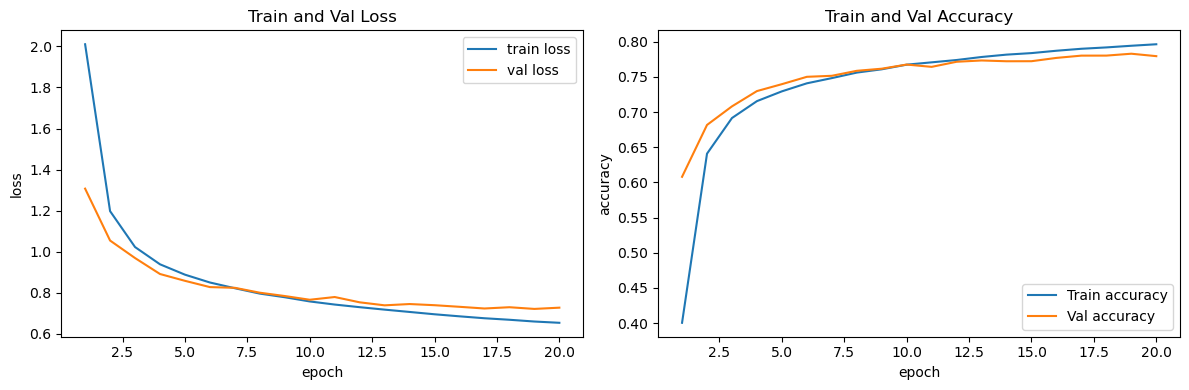

In [20]:
# your code here
history_dict = history.history
epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["loss"], label="train loss")
plt.plot(epochs, history_dict["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train and Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["accuracy"], label="Train accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Train and Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

Then, evaluate the model on the training and validation sets and print the corresponding loss and accuracy values. You should get a validation accuracy >= 77 if you did everything right.

In [21]:
# your code here

train_loss, train_acc = vit.evaluate(train)
print(f"Train loss: {train_loss:.4f}")
print(f"Train accuracy: {train_acc:.2%}")

val_loss, val_acc = vit.evaluate(val)
print(f"Val loss: {val_loss:.4f}")
print(f"Val accuracy: {val_acc:.2%}")

538/538 [==============================] - 61s 113ms/step - loss: 0.5909 - accuracy: 0.8148
Train loss: 0.5909
Train accuracy: 81.48%
60/60 [==============================] - 8s 134ms/step - loss: 0.7278 - accuracy: 0.7796
Val loss: 0.7278
Val accuracy: 77.96%


<a id="part3"></a>
# PART 3 [10 pts]: The Quick, Draw!  Kaggle competition

[Return to contents](#contents)

<a id="part3kaggle"></a>

## CS1090B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/e067286be2c54c078434793659326610). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS1090B Kaggle competition, please see below and also review. The modeling restrictions DOS and DON'TS are outlined in Kaggle Overview page.

**IMPORTANT NOTES ABOUT SCORING**:

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `label` and needs to contain your class predictions (i.e. 'cat', 'tiger' etc) for each corresponding test observation index location. 
- The **public leaderboard** on Kaggle displays your performance on 45% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 55% of the test set.


**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 5 submissions per team per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW5 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW5 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the training and test data downloaded via the "Data" tab of [the CS1090B competition page linked above](#part2data).**

- **Do not** create multiple accounts on Kaggle.



<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

<a id="q3.1"></a>

**3.1.1**  **Kaggle Competition**

Create a model and use it to compete on Kaggle.


**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results.

**Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).
[https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview)**

</div>

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [23]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["label"])
NUM_CLASSES = len(le.classes_)

# pixel -> image 
X = df_train.drop(columns=["label", "label_enc"]).values.reshape(-1, 28, 28, 1) / 255.0
y = df_train["label_enc"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_test = df_test.drop(columns=["id"]).values.reshape(-1, 28, 28, 1) / 255.0


In [24]:
def build_cnn_model(input_shape=(28, 28, 1), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                      

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop])


Epoch 1/20


2025-05-03 12:23:41.481242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4065/4065 [==============================] - 79s 18ms/step - loss: 1.0233 - accuracy: 0.7040 - val_loss: 0.7250 - val_accuracy: 0.7865
Epoch 2/20
4065/4065 [==============================] - 67s 16ms/step - loss: 0.7185 - accuracy: 0.7862 - val_loss: 0.6014 - val_accuracy: 0.8202
Epoch 3/20
4065/4065 [==============================] - 67s 16ms/step - loss: 0.6463 - accuracy: 0.8053 - val_loss: 0.5372 - val_accuracy: 0.8351
Epoch 4/20
4065/4065 [==============================] - 67s 17ms/step - loss: 0.5986 - accuracy: 0.8177 - val_loss: 0.5162 - val_accuracy: 0.8413
Epoch 5/20
4065/4065 [==============================] - 67s 16ms/step - loss: 0.5701 - accuracy: 0.8259 - val_loss: 0.4980 - val_accuracy: 0.8468
Epoch 6/20
4065/4065 [==============================] - 67s 16ms/step - loss: 0.5474 - accuracy: 0.8315 - val_loss: 0.4938 - val_accuracy: 0.8475
Epoch 7/20
4065/4065 [==============================] - 67s 16ms/step - loss: 0.5284 - accuracy: 0.8361 - val_loss: 0.4816 - val_accura


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.1.2**  Plot your model's training accuracy and and any relevant metrics as a function of epochs.




</div>

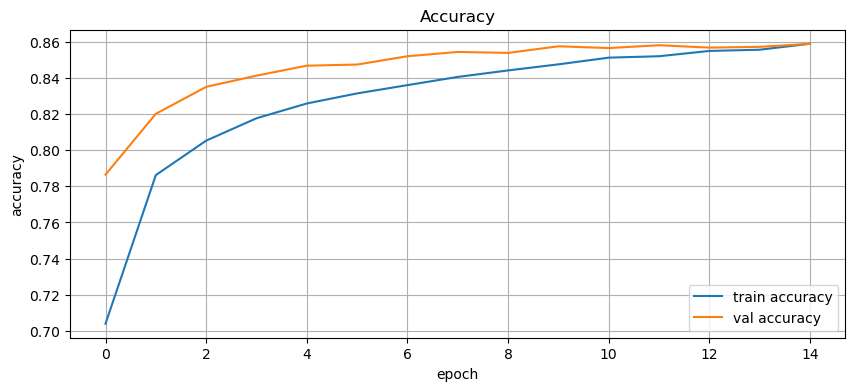

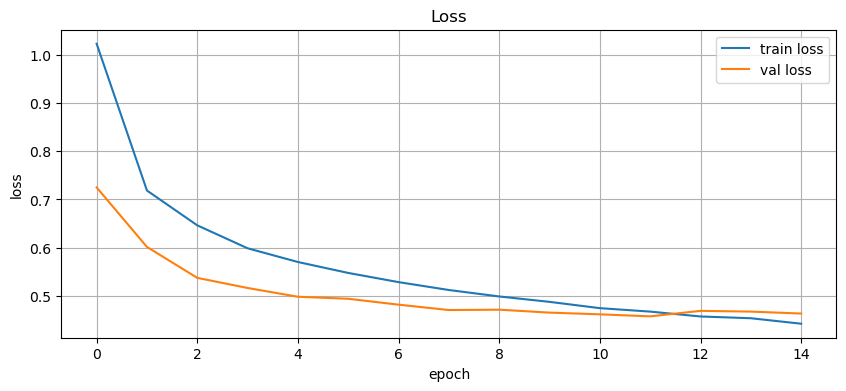

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.1.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your model as well as any observations you might have regarding your training and Kaggle results.


</div>

**APPROACH AND OBSERVATIONS:**

We first tried to make a ViT but we got horrible results, probably because we didn't have enough data and small input size. So we decided to use a deeper CNN model, which works well for low-resolution image classification.  The CNN had way better performance, and had 85% accuracy on the validation set. So we realized in this situation a CNN is better than ViT. We ended up fairly in the middle of the pack around 45th place.


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.2.1**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS1090B Kaggle Competition](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/) for leaderboard scoring. 

**IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 54,000 predictions, the second column must be named `"label"` and needs to contain your class predictions (i.e. `cat` or `dog` etc.) for each corresponding test observation index location. A sample submission file is provided on [Kaggle](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/data?select=sample_submission.csv)
</div>

In [27]:
# your code here
probs = model.predict(X_test)
pred_labels_idx = np.argmax(probs, axis=1)
pred_labels = le.inverse_transform(pred_labels_idx)
sample_sub = pd.read_csv("sample_submission.csv")
submission = pd.DataFrame({
    "id": sample_sub["id"],    
    "label": pred_labels          
})

submission.to_csv("submission.csv", index=False)

1688/1688 [==============================] - 2s 1ms/step



<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.2.2**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

Andrew Lobo

<!-- BEGIN QUESTION -->


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<b>3.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

I think this pset was fair but decently challenging. The labs were very helpful as always with doing his assignment had several challenging parts across all three sections. Part 1 was interesting being able to turn the models and tokenization within Hugging face. Part 2 was also pretty interesting with ViTs and building them and using different techniques. 3 was the most challenging and frustrating because of the whole building the ViT model and then having it not really work - so it became the most time consuming part. I guess it was useful in understanding when to use each - I remember Pavlos talking in lecture about which to use when. So it was a pretty important lesson in choosening the right model.

In [28]:
hours_spent_on_hw = 7 # np.inf

In [29]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 60.53 minutes for this notebook to run


**This concludes HW5... the final CS 1090B HW! Thank you!**